In [1]:
import os
import os.path as osp
import dotenv
import pandas as pd
import numpy as np
import dotenv
import collections
from snorkel import SnorkelSession

dotenv.load_dotenv('../env.sh')
%run ../src/supervision.py
session = SnorkelSession()

REL_INDCK, REL_SECCK, REL_INDTF = 'indck', 'secck', 'indtf'
REL_ABBRS = collections.OrderedDict([
    (REL_INDCK, REL_CLASS_INDUCING_CYTOKINE),
    (REL_SECCK, REL_CLASS_SECRETED_CYTOKINE),
    (REL_INDTF, REL_CLASS_INDUCING_TRANSCRIPTION_FACTOR),
])

In [2]:
from snorkel.models import Candidate
classes = get_candidate_classes()
c = session.query(classes.inducing_cytokine.subclass).first()
c.get_cids(), c.cytokine_cid, c.immune_cell_type_cid

(('CKC5CC1A269C01EC48:CKC5CC1A269C01EC48',
  'CTBDDE0043F47EDCC1:CTBDDE0043F47EDCC1'),
 'CKC5CC1A269C01EC48:CKC5CC1A269C01EC48',
 'CTBDDE0043F47EDCC1:CTBDDE0043F47EDCC1')

In [3]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    get_left_tokens,
    get_right_tokens,
    get_between_tokens,
    get_text_splits,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

### Text Pattern Functions

In [4]:
%run ../src/supervision.py

TERMS = get_terms_map()

def subst_pattern(pattern, terms=None):
    for k, v in {**TERMS, **(terms or {})}.items():
        pattern = pattern.replace('{{' + k + '}}', v)
    return pattern

def regex_pattern(pattern, terms=None):
    return regex_search(None, pattern, terms=terms, pattern_only=True)
    
def regex_search(c, pattern, terms=None, pattern_only=False):
    # Add possible "cell" token after each cell type reference
    pattern = pattern.replace('{{B}}', '{{B}}( cell| type cell|-type cell)?')
    
    # Apply generic replacements in pattern
    pattern = subst_pattern(pattern, terms=terms)
    
    if pattern_only:
        return pattern
    return rule_regex_search_tagged_text(c, pattern, 1)

TERMS

{'r_diff_n': '(differentiation|formation|generation|polarization|development|induction)',
 'r_diff_v': '(differentiate|form|generate|polarize|develop|differentiates|forms|generates|polarizes|develops)',
 'r_diff_p': '(differentiated|formed|generated|polarized|developed)',
 'r_diff_g': '(differentiating|forming|generating|polarizing|developing)',
 'r_push_n': '(inducer|driver|director|regulator|promoter)',
 'r_push_v': '(induce|drive|direct|regulate|promote|induces|drives|directs|regulates|promotes)',
 'r_push_p': '(induced|drove|driven|directed|regulated|promoted)',
 'r_push_g': '(inducing|driving|directing|regulating|promoting)',
 'r_prod_n': '(producer|production|generator|generation|creator|creation)',
 'r_prod_v': '(produce|generate|create|produces|generates|creates)',
 'r_prod_p': '(produced|generated|created)',
 'r_prod_g': '(producing|generating|creating)',
 'r_secr_n': '(secretor|secretion|expressor|expression|producer|production|releaser|release)',
 'r_secr_v': '(secrete|expre

In [5]:
# LF_REGEX[REL_CLASS_INDUCING_CYTOKINE]['positive'][23]

In [5]:
def add_lf(fn, name=None):
    if name is not None:
        fn.__name__ = name
    # Register function in global namespace
    globals()[fn.__name__] = fn
        
def get_fn(ptn, sign):
    def fn(c):
        return sign * regex_search(c, ptn[0], terms=ptn[1] if len(ptn)>1 else None)
    return fn

def get_agg_fn(ptns, sign, agg):
    fns = [get_fn(ptn, sign) for ptn in ptns]
    def fn(c):
        return agg([f(c) for f in fns])
    return fn

# Set to true to roll all text pattern functions into a single function 
# (since there can be > 30 of them)
use_single_text_pattern_fn = True
if use_single_text_pattern_fn:
    for rcls in LF_REGEX:
        cmap = {v: k for k, v in REL_ABBRS.items()}
        for sign in LF_REGEX[rcls]:
            val = {'positive': 1, 'negative': -1}[sign]
            ptns = LF_REGEX[rcls][sign]
            if len(ptns) == 0:
                continue
            agg = max if val == 1 else min
            add_lf(get_agg_fn(ptns, val, agg), 'LF_{}_txtptn_{}_all'.format(cmap[rcls], sign[:3]))
else:
    for rcls in LF_REGEX:
        cmap = {v: k for k, v in REL_ABBRS.items()}
        for sign in LF_REGEX[rcls]:
            for i, ptn in enumerate(LF_REGEX[rcls][sign]):
                ptn = LF_REGEX[rcls][sign]
                val = {'positive': 1, 'negative': -1}[sign]
                add_lf(get_fn(ptn, val), 'LF_{}_txtptn_{}_{}'.format(cmap[rcls], sign[:3], i + 1))


In [33]:
# text = 'The current {{A}}-(pos) cells'
# pattern = regex_pattern(r'{{A}}(\+|-)?(positive|negative|\(pos\)|neg|hi|lo)')
# print(pattern)
# m = re.search(pattern, text, flags=re.I)
# m is not None, m

### Heuristic Functions

In [6]:
# Universal function to check for references that are over a certain number of words away, 
# making them unlikely to have any kind of relationship
def is_ref_too_far(c, max_words=25):
    n = len(list(get_between_tokens(c)))
    return -1 if n > max_words else 0
for abbr in REL_ABBRS:
    add_lf(lambda c: is_ref_too_far(c), 'LF_' + abbr + '_heur_distref')
    
def is_a_before_b(c):
    # Return signed result for whether or not first entity type appears before second
    text = get_tagged_text(c)
    return 1 if text.index('{{A}}') < text.index('{{B}}') else -1
add_lf(lambda c: is_a_before_b(c), 'LF_indck_heur_a_before_b')    # Often mentioned as cytokine induces cell 
add_lf(lambda c: -1*is_a_before_b(c), 'LF_secck_heur_a_before_b') # Order reversed typically (i.e. cell then cytokine)


def get_kwds(term_prefixes):
    return set([ 
        kw
        for prefix in term_prefixes
        for k, v in TERMS.items() if k.startswith(prefix)
        for kw in re.findall('\w+', v)
    ])

INDCK_KWS = get_kwds(['r_push', 'r_diff'])
SECCK_KWS = get_kwds(['r_secr'])

             
def has_kwds(c, kwds, window=8):
    words = list(get_left_tokens(c, window=8)) + list(get_between_tokens(c)) + list(get_right_tokens(c, window=8))
    return len(kwds.intersection(words)) > 0

def LF_indck_heur_kwds(c):
    f1, f2 = has_kwds(c, INDCK_KWS), has_kwds(c, SECCK_KWS)
    if f1 and not f2:
        return 1
    if f2 and not f1:
        return -1
    return 0

def LF_secck_heur_kwds(c):
    return -1 * LF_indck_heur_kwds(c)

def has_closer_reference(c, right=True):
    """Determine if there is a closer entity reference in a relation
    
    Args:
        right: If true, this indicates that the right-most entity defined in a two-entity
            relation will be the "source" and the left-most entity will be the "target" 
            (and vise-versa when false).  This is true regardless of the order of the 
            appearance of the entities in a candidate -- i.e. if the relation is defined
            as [cytokine, cell_type], then saying right=True is equivalent to looking
            for a closer cytokine to the cell type than the current one.
    Returns:
        1 or 0 indicating whether or not another target entity exists around the source entity
        within a distance half that on either side of the source entity of the original distance
        between the two (1 if true).
    """
    # Candidates are list of "Context" objects (Spans in this case) which will
    # always be in the order of the entity types defined for the relation class
    source_span, target_span = (c[1], c[0]) if right else (c[0], c[1])
    first_span, last_span = (c[0], c[1]) if is_a_before_b(c) > 0 else (c[1], c[0])
        
    # Get word index start/end using original ordering of entities
    dist = last_span.get_word_start() - first_span.get_word_end()
    assert dist >= 0, \
        'Candidate ({}) has distance ({}) between references < 0'.format(c, dist)
    
    # "source" = entity type to search around, "target" = entity type to search for
    sent = c.get_parent()
    target_typ = sent.entity_types[target_span.get_word_start()]
    assert len(target_typ) > 0, 'Candidate ({}) has empty target type'.format(c)
    target_cid = sent.entity_cids[target_span.get_word_start()].split(':')[-1]
    
    # Search within a dist // 2 window around the target entity for an entity of the 
    # OTHER type, that is not equal to the non-target entity type within this candidate
    start = max(0, source_span.get_word_start() - dist // 2)
    end = min(len(sent.words), source_span.get_word_end() + dist // 2)
    for i in range(start, end):
        if source_span.get_word_start() <= i <= source_span.get_word_end():
            continue
        ent_typ, cid = sent.entity_types[i], sent.entity_cids[i].split(':')[-1]
        if ent_typ == target_typ and cid != target_cid:
            return 1
    return 0
        
def LF_indck_heur_closer_ck_to_ct(c):
    return -1*has_closer_reference(c, right=True)

def LF_indck_heur_closer_ct_to_ck(c):
    return -1*has_closer_reference(c, right=False)

def LF_indck_heur_closer_ref(c):
    return min(LF_indck_heur_closer_ck_to_ct(c), LF_indck_heur_closer_ct_to_ck(c))

def LF_secck_heur_closer_ck_to_ct(c):
    return -1*has_closer_reference(c, right=True)

def LF_secck_heur_closer_ct_to_ck(c):
    return -1*has_closer_reference(c, right=False)

def LF_secck_heur_closer_ref(c):
    return min(LF_secck_heur_closer_ck_to_ct(c), LF_secck_heur_closer_ct_to_ck(c))

### Distant Supervision Functions

In [7]:
df_ix = pd.read_csv(osp.join(os.environ['SUPERVISION_DATA_DIR'], 'immunexpresso', 'data.csv'))

# Filter to records with known cell/cytokine mappings for internal IDS
df_ix = df_ix[df_ix['cell_ref_id'].notnull() & df_ix['cytokine_ref_id'].notnull()]
# Also filter to records with >= 6 publications, as classification is a bit noisy
df_ix = df_ix[df_ix['num_papers'] >= 6]
print(df_ix.info())
df_ix = df_ix.set_index(['cell_ref_id', 'cytokine_ref_id']).sort_index()

def is_known_ix_relation(c, actor, category):
    # Actor = 'cytokine' implies induction relationship where category in ['Positive', 'Negative', 'Unknown']
    # Actor = 'cell' implies secreation relationship and category is always 'Positive'
    
    # Split ids saved as "<matched id>:<preferred id>" to do lookup on preferred id
    ct_id, ck_id = c.immune_cell_type_cid, c.cytokine_cid
    ct_id, ck_id = ct_id.split(':')[1], ck_id.split(':')[1]
    if (ct_id, ck_id) in df_ix.index:
        df = df_ix.loc[(ct_id, ck_id)]
        df = df[(df['actor'] == actor) & (df['category'] == category)]
        return len(df) > 0
    return None

def LF_indck_dsup_imexpresso(c):
    ind1 = is_known_ix_relation(c, 'cytokine', 'Positive')
    if ind1 is None:
        return 0
    ind2 = is_known_ix_relation(c, 'cytokine', 'Negative')
    ind3 = is_known_ix_relation(c, 'cell', 'Positive')
    if ind1:
        return 1
    if ind2 or ind3:
        return -1
    return 0

def LF_secck_dsup_imexpresso(c):
    ind1 = is_known_ix_relation(c, 'cell', 'Positive')
    if ind1 is None:
        return 0
    ind2 = is_known_ix_relation(c, 'cytokine', 'Positive')
    ind3 = is_known_ix_relation(c, 'cytokine', 'Negative')
    if ind1:
        return 1
    if ind2 or ind3:
        return -1
    return 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107 entries, 13 to 276
Data columns (total 10 columns):
actor              107 non-null object
category           107 non-null object
cell_id            107 non-null object
cell_label         107 non-null object
cytokine_id        107 non-null object
cytokine_label     107 non-null object
num_papers         107 non-null int64
score              107 non-null float64
cell_ref_id        107 non-null object
cytokine_ref_id    107 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 9.2+ KB
None


In [8]:
#df_ix.head()

In [8]:
dft = df_ix[(df_ix['actor'] == 'cytokine') & (df_ix['category'] == 'Positive')].sort_values('num_papers', ascending=False)
dft[dft['cell_label'] == 'T-helper 1 cell'].head(10)

actor  category     cell_id  \
cell_ref_id        cytokine_ref_id                                      
CTC3A8C3CBC245616A CKB4EB2D2CC8BBB93D  cytokine  Positive  CL_0000545   
                   CK128EC732B281BF60  cytokine  Positive  CL_0000545   
                   CKC5CC1A269C01EC48  cytokine  Positive  CL_0000545   
                   CK6FE135B3F86FB707  cytokine  Positive  CL_0000545   
                   CKBF6003C60D23BA0D  cytokine  Positive  CL_0000545   
                   CKBA47332D395669A3  cytokine  Positive  CL_0000545   

                                            cell_label cytokine_id  \
cell_ref_id        cytokine_ref_id                                   
CTC3A8C3CBC245616A CKB4EB2D2CC8BBB93D  T-helper 1 cell      CID_95   
                   CK128EC732B281BF60  T-helper 1 cell      CID_83   
                   CKC5CC1A269C01EC48  T-helper 1 cell      CID_93   
                   CK6FE135B3F86FB707  T-helper 1 cell     CID_131   
                   CKBF6003C60D23BA0D  T-helper 1 cell     CID_108   
                   CKBA47332D395669A3  T-helper 1 cell     CID_500   

                                      cytokine_label  num_papers  score  
cell_ref_id        cytokine_ref_id                                       
CTC3A8C3CBC245616A CKB4EB2D2CC8BBB93D           IL12          56  11.77  
                   CK128EC732B281BF60           IFNG          18   0.68  
                   CKC5CC1A269C01EC48           IL10          13   1.29  
                   CK6FE135B3F86FB707            IL4           7   0.84  
                   CKBF6003C60D23BA0D           IL18           7   4.63  
                   CKBA47332D395669A3           IL27           6   9.06

#### LF Testing

In [12]:
# c = session.query(candidate_class).filter(candidate_class.id == 32753).all()[0]
# c.cytokine_cid, c.immune_cell_type_cid

In [130]:
#df_ix.loc[('CTC3A8C3CBC245616A', 'CKB4EB2D2CC8BBB93D')]

In [9]:
from snorkel.viewer import SentenceNgramViewer
from snorkel.annotations import load_gold_labels

candidate_class = classes.inducing_cytokine
# Load all dev labels for this relation class
L_dev = load_gold_labels(
    session, annotator_name=candidate_class.field, 
    split=1, load_as_array=False, 
    cids_query=get_cids_query(session, candidate_class, 1)
)
# Filter to get list of candidates where label is positive
L_dev_pos_cands = [L_dev.get_candidate(session, i) for i in np.argwhere(L_dev.toarray().squeeze()).squeeze()]

In [10]:
cands = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 1).all()
labeled, gold = [], []
gold_ids = [c.id for c in L_dev_pos_cands]
for c in cands:
    #if LF_indck_txtptn_pos_24(c) == 1:
    #if LF_ind_pos_imexpresso(c) == 1:
    #if LF_indck_a_before_b(c) == -1:
    #if LF_indck_kwds(c) == -1:
    #if LF_indck_heur_closer_ck_to_ct(c) == -1:
    if LF_indck_txtptn_pos_all(c) == 1:
        labeled.append(c)
        if c.id in gold_ids:
            gold.append(c)
    #gold.append(c)

print("Number labeled =", len(labeled), ", num gold =", len(gold))
# - ID in hover state is sentence id (c.get_parent().id)
# - Cell type label will be blue if candidate is NOT in "gold" set and red otherwise
SentenceNgramViewer(labeled, session, gold=gold)

Number labeled = 121 , num gold = 74


<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[0], [23, 76], [110, 114]], [[10], [44, 45], [59, 60]], [[92], [86, 96, 101, 102, 1…

In [74]:
from snorkel.models import Sentence
s = session.query(Sentence).filter(Sentence.id==3106).one()
s

Sentence(Document PMC2196041,7,b'Th2 cells secrete mainly IL-4, IL-5, IL-6, IL-10, and IL-13, which mediate B cell activation, antibody production, and the regulation of Th1 responses (for review see reference 1).')

In [14]:
def get_candidates(sent_ids):
    cands = session.query(candidate_class.subclass)\
        .filter(candidate_class.subclass.split == 1).all()
    return [c for c in cands if c.get_parent().id in sent_ids]
sent_cands = get_candidates([3106])
#sent_cands = [c for c in sent_cands if c.get_contexts()[0].get_span() == 'IL-6']
#sent_cands

In [113]:
sent_cands[1].id in [c.id for c in L_dev_pos_cands]

False

### Composite Functions

In [37]:
def _global_lfs():
    return {
        k:v for k, v in globals().items() 
        if callable(v) and k.startswith('LF_')
    }

def get_lfs(filter_fn=None): 
    lfs = _global_lfs()
    if filter_fn is None:
        filter_fn = lambda n: True
    res = collections.OrderedDict([
        (k, lfs[k]) for k in sorted(lfs.keys()) 
        if filter_fn(k)
    ])
    return res

fns_indck_neg_sec = get_lfs(lambda k: k.startswith('LF_secck_txtptn_pos') or k.startswith('LF_secck_heur'))
print('LF_indck_neg_sec: Num functions composed = {} (names = {})'.format(
    len(fns_indck_neg_sec), list(fns_indck_neg_sec.keys())
))
def LF_indck_comp_neg_sec(c):
    # Create function that returns -1 for inducing cytokines anytime a positive hit is found on secretion
    # * should return -1 or 0
    return min(-1*max([f(c) for f in fns_indck_neg_sec.values()]), 0)

fns_secck_neg_ind = get_lfs(lambda k: k.startswith('LF_indck_txtptn_pos') or k.startswith('LF_indck_heur'))
print('LF_secck_neg_ind: Num functions composed = {} (names = {})'.format(
    len(fns_secck_neg_ind), list(fns_secck_neg_ind.keys())
))

def LF_secck_comp_neg_ind(c):
    # Create function that returns -1 for inducing cytokines anytime a positive hit is found on secretion
    # * should return -1 or 0
    return min(-1*max([f(c) for f in fns_secck_neg_ind.values()]), 0)


def LF_indck_comp_imexpresso(c):
    skip = min(LF_indck_heur_distref(c), LF_indck_comp_neg_sec(c), LF_indck_heur_closer_ref(c))
    return LF_indck_dsup_imexpresso(c) if not skip else 0

def LF_secck_comp_imexpresso(c):
    skip = min(LF_secck_heur_distref(c), LF_secck_comp_neg_ind(c), LF_secck_heur_closer_ref(c))
    return LF_secck_dsup_imexpresso(c) if not skip else 0

# Function used to "attenuate" a function using strong indicators of
# negative examples -- attenuating functions typically return either 0 or -1
# def attenuate_fn(original_fn, attenuating_fns):
#     def fn(c):
#         skip = min([f(c) for f in attenuating_fns]) < 0
#         val = original_fn(c)
#         return val if not skip else 0
#     return fn
    
# indck_attenuate_fns = [LF_indck_distref, LF_indck_neg_sec]
# for k, fn in get_lfs(lambda k: k.startswith('LF_indck')).items():
#     if fn in indck_attenuate_fns or '_attenuated' in k:
#         continue
#     add_lf(attenuate_fn(fn, indck_attenuate_fns), k + '_attenuated')
    
# secck_attenuate_fns = [LF_secck_distref, LF_secck_neg_ind]
# for k, fn in get_lfs(lambda k: k.startswith('LF_secck')).items():
#     if fn in secck_attenuate_fns or '_attenuated' in k:
#         continue
#     add_lf(attenuate_fn(fn, secck_attenuate_fns), k + '_attenuated')

LF_indck_neg_sec: Num functions composed = 7 (names = ['LF_secck_heur_a_before_b', 'LF_secck_heur_closer_ck_to_ct', 'LF_secck_heur_closer_ct_to_ck', 'LF_secck_heur_closer_ref', 'LF_secck_heur_distref', 'LF_secck_heur_kwds', 'LF_secck_txtptn_pos_all'])
LF_secck_neg_ind: Num functions composed = 7 (names = ['LF_indck_heur_a_before_b', 'LF_indck_heur_closer_ck_to_ct', 'LF_indck_heur_closer_ct_to_ck', 'LF_indck_heur_closer_ref', 'LF_indck_heur_distref', 'LF_indck_heur_kwds', 'LF_indck_txtptn_pos_all'])


In [38]:
#[f(c) for f in fns_indck_neg_sec.values()]

In [39]:
LFs = collections.OrderedDict()
LFs[REL_CLASS_INDUCING_CYTOKINE] = get_lfs(lambda k: k.startswith('LF_indck')).values()
LFs[REL_CLASS_SECRETED_CYTOKINE] = get_lfs(lambda k: k.startswith('LF_secck')).values()
for k in LFs:
    print('{} labeling functions:'.format(k))
    for f in LFs[k]:
        print(f.__name__)
    print()
#print('Labeling functions found:\n{}'.format('\n'.join([str((k, f.__name__)) for k in LFs for f in LFs[k]])))

InducingCytokine labeling functions:
LF_indck_comp_imexpresso
LF_indck_comp_neg_sec
LF_indck_dsup_imexpresso
LF_indck_heur_a_before_b
LF_indck_heur_closer_ck_to_ct
LF_indck_heur_closer_ct_to_ck
LF_indck_heur_closer_ref
LF_indck_heur_distref
LF_indck_heur_kwds
LF_indck_txtptn_neg_all
LF_indck_txtptn_pos_all

SecretedCytokine labeling functions:
LF_secck_comp_imexpresso
LF_secck_comp_neg_ind
LF_secck_dsup_imexpresso
LF_secck_heur_a_before_b
LF_secck_heur_closer_ck_to_ct
LF_secck_heur_closer_ct_to_ck
LF_secck_heur_closer_ref
LF_secck_heur_distref
LF_secck_heur_kwds
LF_secck_txtptn_pos_all



## Apply Labeling to Candidates

In [40]:
for c in classes.values():
    for split in [0, 1]:
        n = session.query(c.subclass).filter(c.subclass.split == split).count()
        print('Candidate counts: {} (split {}) -> {}'.format(c.name, split, n))

Candidate counts: InducingCytokine (split 0) -> 11836
Candidate counts: InducingCytokine (split 1) -> 593
Candidate counts: SecretedCytokine (split 0) -> 11836
Candidate counts: SecretedCytokine (split 1) -> 593
Candidate counts: InducingTranscriptionFactor (split 0) -> 8477
Candidate counts: InducingTranscriptionFactor (split 1) -> 406


In [43]:
from snorkel.models import Candidate
from snorkel.annotations import LabelAnnotator
from snorkel.annotations import load_gold_labels

def run_labeling(candidate_class, lfs, split, replace_key_set=True, has_gold_labels=False):
    cids_query = get_cids_query(session, candidate_class, split)
    y = None
    if has_gold_labels:
        y = load_gold_labels(
            session, annotator_name=candidate_class.field, 
            split=split, load_as_array=True, cids_query=cids_query)
        y = np.where(y == 1, 1, -1)
        assert np.all(np.in1d(y, [-1, 1]))
    
    print('Running labeling for class {}, split {}'.format(candidate_class.name, split))
    labeler = LabelAnnotator(lfs=lfs)
    X = labeler.apply(split=split, cids_query=cids_query, replace_key_set=replace_key_set)
    stats = X.lf_stats(session, y)
    
    return X, y, stats, labeler

res_label = collections.defaultdict(dict)
for c in classes:
    if c not in LFs:
        continue
    for split in [0, 1]:
#     for split in [1]:
        res_label[c][split] = run_labeling(classes[c], LFs[c], split, has_gold_labels=split>0)


  0%|          | 6/11836 [00:00<03:19, 59.27it/s]

Running labeling for class InducingCytokine, split 0
Clearing existing...
Running UDF...



 10%|█         | 1190/11836 [00:17<02:21, 75.09it/s]


 19%|█▉        | 2275/11836 [00:34<02:16, 70.19it/s]


 29%|██▉       | 3426/11836 [00:51<02:04, 67.62it/s]


 40%|███▉      | 4693/11836 [01:08<01:23, 85.50it/s]


 49%|████▉     | 5827/11836 [01:25<01:21, 73.85it/s]


 59%|█████▉    | 6979/11836 [01:42<01:04, 75.13it/s]


 70%|██████▉   | 8242/11836 [01:59<00:47, 75.66it/s]


 80%|████████  | 9501/11836 [02:17<00:31, 74.30it/s]


 89%|████████▉ | 10532/11836 [02:34<00:18, 68.98it/s]


 99%|█████████▉| 11725/11836 [02:52<00:01, 81.26it/s]


  0%|          | 0/593 [00:00<?, ?it/s]

Running labeling for class InducingCytokine, split 1
Clearing existing...
Running UDF...



  0%|          | 7/11836 [00:00<02:49, 69.63it/s]

Running labeling for class SecretedCytokine, split 0
Clearing existing...
Running UDF...



 11%|█         | 1294/11836 [00:17<02:16, 77.08it/s]


 22%|██▏       | 2581/11836 [00:33<02:17, 67.50it/s]


 32%|███▏      | 3842/11836 [00:50<01:53, 70.49it/s]


 43%|████▎     | 5129/11836 [01:07<01:58, 56.56it/s]


 52%|█████▏    | 6209/11836 [01:24<01:52, 49.89it/s]


 63%|██████▎   | 7429/11836 [01:41<00:56, 78.62it/s]


 73%|███████▎  | 8698/11836 [01:58<00:40, 77.64it/s]


 84%|████████▎ | 9910/11836 [02:16<01:23, 22.95it/s]


 94%|█████████▎| 11074/11836 [02:34<00:15, 49.34it/s]


  0%|          | 0/593 [00:00<?, ?it/s]

Running labeling for class SecretedCytokine, split 1
Clearing existing...
Running UDF...



100%|██████████| 593/593 [00:08<00:00, 73.44it/s]

In [44]:
from IPython.display import display
for c in res_label:
    for split in res_label[c]:
        print('Stats {} (split {}):'.format(c, split))
        display(res_label[c][split][2])

Stats InducingCytokine (split 0):


,j,Coverage,Overlaps,Conflicts
LF_indck_comp_imexpresso,0,0.113214,0.113214,0.043258
LF_indck_comp_neg_sec,1,0.596232,0.596232,0.313366
LF_indck_dsup_imexpresso,2,0.466458,0.466458,0.308043
LF_indck_heur_a_before_b,3,1.000000,0.938577,0.520953
LF_indck_heur_closer_ck_to_ct,4,0.235046,0.235046,0.156894
LF_indck_heur_closer_ct_to_ck,5,0.192548,0.192548,0.133576
LF_indck_heur_closer_ref,6,0.330602,0.330602,0.224147
LF_indck_heur_distref,7,0.229300,0.229300,0.153937
LF_indck_heur_kwds,8,0.492143,0.492143,0.311761
LF_indck_txtptn_neg_all,9,0.019686,0.019686,0.018249


Stats InducingCytokine (split 1):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_indck_comp_imexpresso,0,0.112985,0.112985,0.052277,20,16,11,20,0.597015
LF_indck_comp_neg_sec,1,0.561551,0.561551,0.256324,0,0,29,304,0.912913
LF_indck_dsup_imexpresso,2,0.435076,0.435076,0.295110,47,97,16,98,0.562016
LF_indck_heur_a_before_b,3,1.000000,0.964587,0.507589,83,215,29,266,0.588533
LF_indck_heur_closer_ck_to_ct,4,0.318718,0.318718,0.209106,0,0,24,165,0.873016
LF_indck_heur_closer_ct_to_ck,5,0.264755,0.264755,0.151771,0,0,8,149,0.949045
LF_indck_heur_closer_ref,6,0.414840,0.414840,0.266442,0,0,30,216,0.878049
LF_indck_heur_distref,7,0.241147,0.241147,0.109612,0,0,5,138,0.965035
LF_indck_heur_kwds,8,0.529511,0.529511,0.313659,69,123,0,122,0.608280
LF_indck_txtptn_neg_all,9,0.015177,0.015177,0.015177,0,0,0,9,1.000000


Stats SecretedCytokine (split 0):


,j,Coverage,Overlaps,Conflicts
LF_secck_comp_imexpresso,0,0.122508,0.122508,0.012335
LF_secck_comp_neg_ind,1,0.617776,0.617776,0.351893
LF_secck_dsup_imexpresso,2,0.466458,0.466458,0.317168
LF_secck_heur_a_before_b,3,1.000000,0.940014,0.528810
LF_secck_heur_closer_ck_to_ct,4,0.235046,0.235046,0.163484
LF_secck_heur_closer_ct_to_ck,5,0.192548,0.192548,0.137884
LF_secck_heur_closer_ref,6,0.330602,0.330602,0.236482
LF_secck_heur_distref,7,0.229300,0.229300,0.162555
LF_secck_heur_kwds,8,0.492143,0.492143,0.299932
LF_secck_txtptn_pos_all,9,0.073927,0.073927,0.029148


Stats SecretedCytokine (split 1):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_secck_comp_imexpresso,0,0.097808,0.097808,0.006745,33,21,0,4,0.637931
LF_secck_comp_neg_ind,1,0.612142,0.612142,0.327150,0,0,3,360,0.991736
LF_secck_dsup_imexpresso,2,0.435076,0.435076,0.293423,42,166,0,50,0.356589
LF_secck_heur_a_before_b,3,1.000000,0.959528,0.539629,62,233,3,295,0.602024
LF_secck_heur_closer_ck_to_ct,4,0.318718,0.318718,0.217538,0,0,10,179,0.947090
LF_secck_heur_closer_ct_to_ck,5,0.264755,0.264755,0.198988,0,0,0,157,1.000000
LF_secck_heur_closer_ref,6,0.414840,0.414840,0.295110,0,0,10,236,0.959350
LF_secck_heur_distref,7,0.241147,0.241147,0.192243,0,0,2,141,0.986014
LF_secck_heur_kwds,8,0.529511,0.529511,0.291737,50,72,0,192,0.770701
LF_secck_txtptn_pos_all,9,0.096121,0.096121,0.026981,39,18,0,0,0.684211


In [31]:
# df_dev = pd.DataFrame(L_dev.toarray()).assign(label=L_gold_dev)
# df_dev.head(3)

In [251]:
# lf_idx = [f.__name__ for f in LFs].index('LF_ind_pos_1')
# lf_hits = df_dev[df_dev[lf_idx] > 0]
# cands = [dev_cands[i] for i in lf_hits.index]
# print(cands)
# lf_hits

## Train Generative Model

In [71]:
res_label.keys()

dict_keys(['InducingCytokine', 'SecretedCytokine'])

In [73]:
from snorkel.learning.structure import DependencySelector
from snorkel.learning import GenerativeModel

res_train = {}
for c in res_label:
    print('Running generative model training for class {}'.format(c))
    ds = DependencySelector()
    split = 0
    X = res_label[c][split][0]
    deps = ds.select(X, threshold=0.1)
    gen_model = GenerativeModel(lf_propensity=True)
    gen_model.train(
        X, deps=deps, decay=0.95, 
        step_size=0.1/X.shape[0], reg_param=0.0
    )
    marginals = gen_model.marginals(X)
    res_train[c] = gen_model, X, marginals, deps

Running generative model training for class InducingCytokine
Inferred cardinality: 2
Running generative model training for class SecretedCytokine
Inferred cardinality: 2


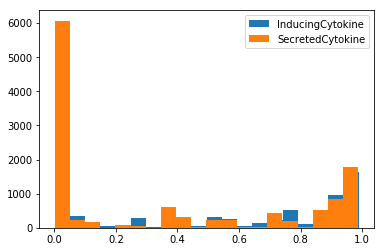

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
for c in res_train:
    plt.hist(res_train[c][2], bins=20, label=c)
    plt.legend()

In [29]:
# from IPython.display import display
# for c in res_train:
#     print(c)
#     display(res_train[c][0].learned_lf_stats())

In [75]:
from snorkel.annotations import save_marginals

# Fetch the candidates for each class into a SINGLE list and do
# the same for the marginal arrays since the `save_marginals` function
# deletes all records (with no arguments for filters to avoid this) each time,
# making it impossible to call separately for each set of candidates
candidates, marginals = [], []
for c in res_train:
    X, y = res_train[c][1], res_train[c][2]
    candidates.extend([X.get_candidate(session, i) for i in range(X.shape[0])])
    marginals.append(y)
marginals = np.concatenate(marginals)
assert len(candidates) == len(marginals)
save_marginals(session, candidates, marginals)

Saved 23672 marginals


In [76]:
from snorkel.models import Marginal, Candidate

# Determine the candidate types for all saved marginals
cids = [m.candidate_id for m in session.query(Marginal).all()]
pd.DataFrame(
    session.query(Candidate.id, Candidate.type).filter(Candidate.id.in_(cids)),
    columns=['id', 'type']
).groupby('type').size()

type
inducing_cytokine    11836
secreted_cytokine    11836
dtype: int64

In [36]:
# _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

In [37]:
# L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])